### Solution 1. Instruction-tune using trl

https://www.philschmid.de/instruction-tune-llama-2

#### 1. Define the use case and create a prompt template for instructions

- Alpaca format 

    ```comment
    ### Instruction:
    Use the Input below to create an instruction, which could have been used to generate the input using an LLM.

    ### Input:
    Dear [boss name],

    I'm writing to request next week, August 1st through August 4th,
    off as paid time off.

    I have some personal matters to attend to that week that require
    me to be out of the office. I wanted to give you as much advance
    notice as possible so you can plan accordingly while I am away.

    Please let me know if you need any additional information from me
    or have any concerns with me taking next week off. I appreciate you
    considering this request.

    Thank you, [Your name]

    ### Response:
    Write an email to my boss that I need next week 08/01 - 08/04 off.
    ```

#### 2. Create an instruction dataset

In [ ]:
!pip install "transformers==4.31.0" "datasets==2.13.0" "peft==0.4.0" "accelerate==0.21.0" "bitsandbytes==0.40.2" "trl==0.4.7" "safetensors>=0.3.1" --upgrade

In [ ]:
from datasets import load_dataset
from random import randrange

# Load dataset from the hub
dataset = load_dataset("databricks/databricks-dolly-15k", split="train")

print(f"dataset size: {len(dataset)}")
print(dataset[randrange(len(dataset))])
# dataset size: 15011

In [ ]:
def format_instruction(sample):
	return f"""### Instruction:
Use the Input below to create an instruction, which could have been used to generate the input using an LLM.

### Input:
{sample['response']}

### Response:
{sample['instruction']}
"""

In [ ]:
from random import randrange

print(format_instruction(dataset[randrange(len(dataset))]))

```comment
### Instruction:
Use the Input below to create an instruction, which could have been used to generate the input using an LLM.

### Input:
22nd July 1947

### Response:
When was the Indian National Flag adopted
```

#### 3. Instruction-tune Llama 2 using trl and the SFTTrainer

In [ ]:
!python -c "import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'"
!pip install ninja packaging
!MAX_JOBS=4 pip install flash-attn --no-build-isolation

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

use_flash_attention = False
# COMMENT IN TO USE FLASH ATTENTION
# replace attention with flash attention
# if torch.cuda.get_device_capability()[0] >= 8:
#     from utils.llama_patch import replace_attn_with_flash_attn
#     print("Using flash attention")
#     replace_attn_with_flash_attn()
#     use_flash_attention = True


# Hugging Face model id
model_id = "NousResearch/Llama-2-7b-hf" # non-gated
# model_id = "meta-llama/Llama-2-7b-hf" # gated


# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, use_cache=False, device_map="auto")
model.config.pretraining_tp = 1

# Validate that the model is using flash attention, by comparing doc strings
if use_flash_attention:
    from utils.llama_patch import forward
    assert model.model.layers[0].self_attn.forward.__doc__ == forward.__doc__, "Model is not using flash attention"


tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

# LoRA config based on QLoRA paper
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.1,
        r=64,
        bias="none",
        task_type="CAUSAL_LM",
)


# prepare model for training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="llama-7-int4-dolly",
    num_train_epochs=3,
    per_device_train_batch_size=6 if use_flash_attention else 4,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,
    tf32=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    disable_tqdm=True # disable tqdm since with packing values are in correct
)

In [ ]:
from trl import SFTTrainer

max_seq_length = 2048 # max sequence length for model and packing of the dataset

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    packing=True,
    formatting_func=format_instruction,
    args=args,
)

In [ ]:
# train
trainer.train() # there will not be a progress bar since tqdm is disabled

# save model
trainer.save_model()

#### 4. Test Model and run Inference

In [ ]:
if use_flash_attention:
    # unpatch flash attention
    from utils.llama_patch import unplace_flash_attn_with_attn
    unplace_flash_attn_with_attn()

import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

args.output_dir = "llama-7-int4-dolly"

# load base LLM model and tokenizer
model = AutoPeftModelForCausalLM.from_pretrained(
    args.output_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(args.output_dir)

In [ ]:
from datasets import load_dataset
from random import randrange


# Load dataset from the hub and get a sample
dataset = load_dataset("databricks/databricks-dolly-15k", split="train")
sample = dataset[randrange(len(dataset))]

prompt = f"""### Instruction:
Use the Input below to create an instruction, which could have been used to generate the input using an LLM.

### Input:
{sample['response']}

### Response:
"""

input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
# with torch.inference_mode():
outputs = model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.9)

print(f"Prompt:\n{sample['response']}\n")
print(f"Generated instruction:\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")
print(f"Ground truth:\n{sample['instruction']}")

```comment
Prompt:
Jack Dorsey, Noah Glass, Biz Stone, Evan Williams

Generated instruction:
Extract the founders of Twitter from the passage. Display the results in a comma separated format.

Ground truth:
List the founders of Twitter from the above passage in a comma separated format.
```

### Solution 2. Huggingface AutoTrain-advanced

https://github.com/huggingface/autotrain-advanced

https://www.youtube.com/watch?v=3fsn19OI_C8

#### Sample Dataset

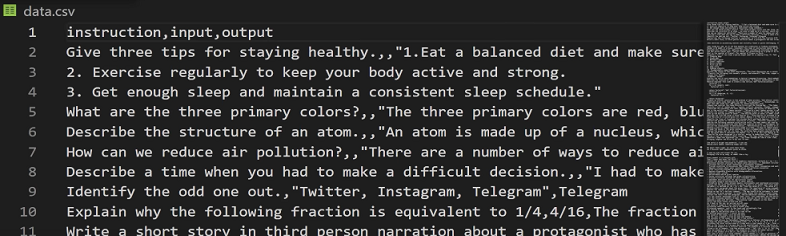

In [ ]:
!pip install autotrain-advanced

#### Setup (optional, required on google colab):

In [ ]:
!autotrain setup --update-torch

#### Train

In [ ]:
!autotrain llm --train --project_name my-llm --model meta-llama/Llama-2-7b-hf --data_path . --use_peft --use_int4 --learning_rate 2e-4 --train_batch_size 12 --num_train_epochs 3 --trainer sft